In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# For validation and test, do not use augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_root = '/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset' 
full_dataset = ImageFolder(root=dataset_root, transform=None)
print("Detected classes:", full_dataset.classes)

Detected classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [5]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [6]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  

    plt.tight_layout()
    plt.show()

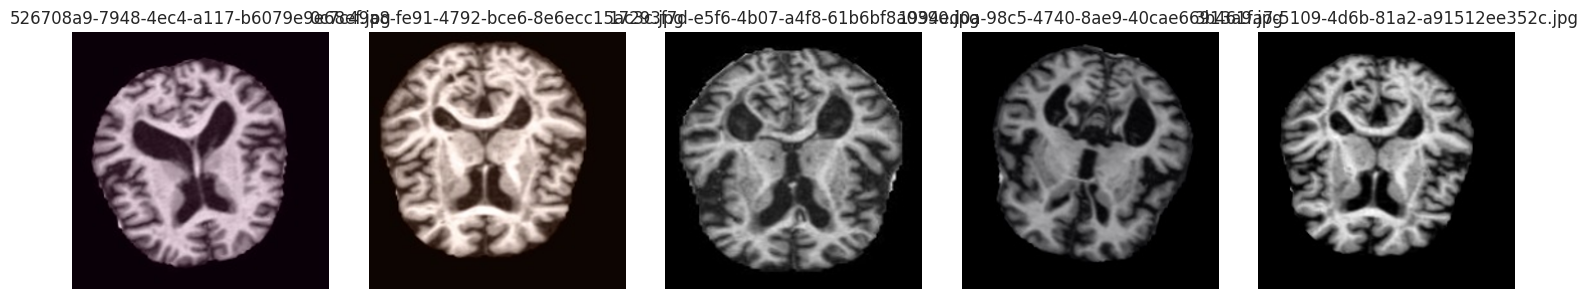

In [7]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented"
visualize_images(path_to_visualize, num_images=5)

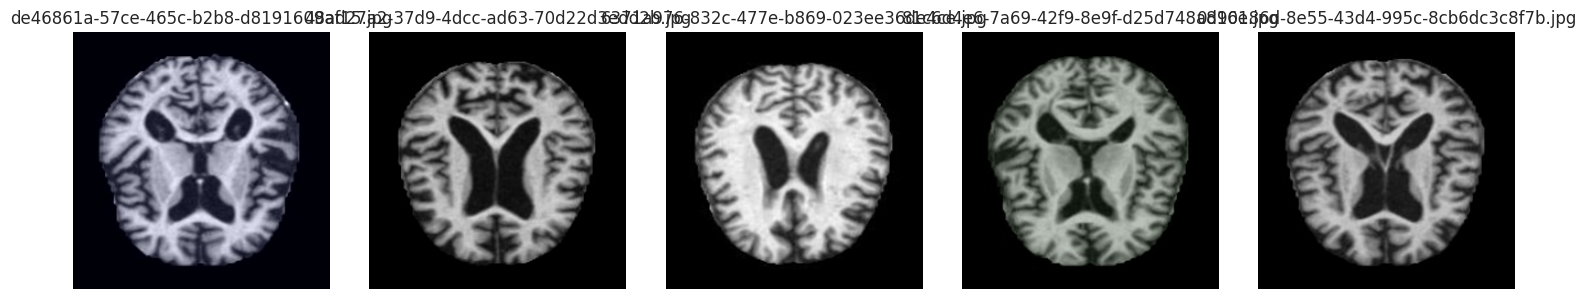

In [8]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented"
visualize_images(path_to_visualize, num_images=5)

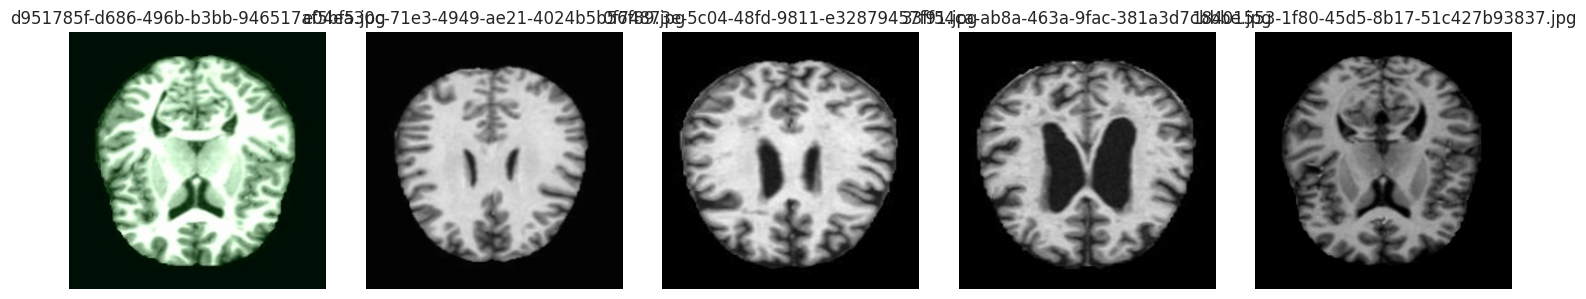

In [9]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented"
visualize_images(path_to_visualize, num_images=5)

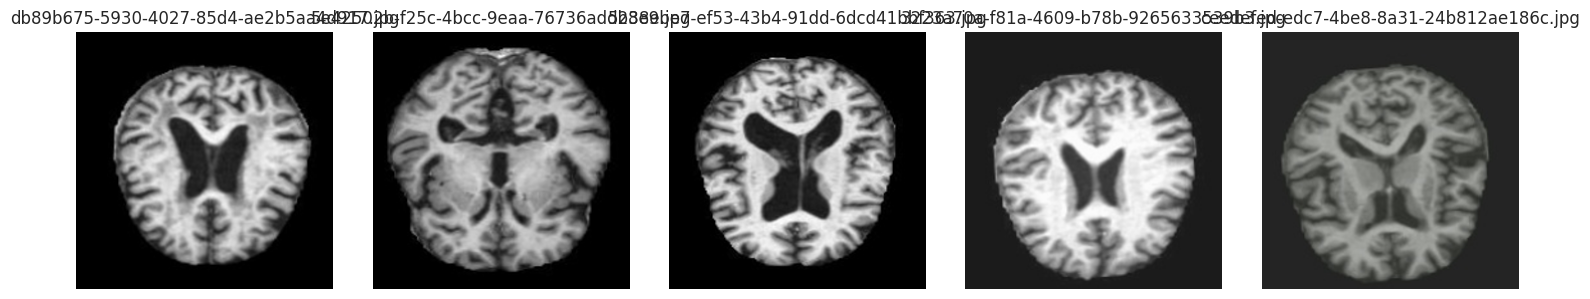

In [10]:
path_to_visualize = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented"
visualize_images(path_to_visualize, num_images=5)

In [11]:
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size 

In [12]:
print(f"Total size: {total_size}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Total size: 33984
Train size: 27187
Validation size: 3398
Test size: 3399


In [13]:
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])
train_dataset = TransformDataset(train_subset, transform=train_transform)
val_dataset   = TransformDataset(val_subset, transform=val_transform)
test_dataset  = TransformDataset(test_subset, transform=val_transform)


In [14]:
batch_size = 64
num_workers = 16  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4

In [16]:
resnet50_model = models.resnet50(pretrained=True)
num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_features, num_classes)
resnet50_model = resnet50_model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 354MB/s]


In [17]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(resnet50_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    best_acc = 0.0
    best_model_wts = None
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
        scheduler.step()

    print("Best validation accuracy: {:.4f}".format(best_acc))
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

def test_model_with_report(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    overall_acc = accuracy_score(all_labels, all_preds)
    print("\nOverall Test Accuracy: {:.4f}".format(overall_acc))

    class_names = full_dataset.classes
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("Per Class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"Class {i} ({class_names[i]}): {acc:.4f}")

    return overall_acc, report, per_class_acc


In [19]:
num_epochs = 20
print("Training ResNet50 on new dataset with 80/10/10 split...")
trained_resnet50, resnet_train_losses, resnet_train_accs, resnet_val_losses, resnet_val_accs = train_model(
    resnet50_model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs
)


Training ResNet50 on new dataset with 80/10/10 split...

Epoch 1/20


Train Loss: 0.8072, Train Acc: 0.6263
Val Loss: 0.5719, Val Acc: 0.7248

Epoch 2/20


Train Loss: 0.5521, Train Acc: 0.7583
Val Loss: 0.3866, Val Acc: 0.8384

Epoch 3/20


Train Loss: 0.4319, Train Acc: 0.8167
Val Loss: 0.3132, Val Acc: 0.8808

Epoch 4/20


Train Loss: 0.3606, Train Acc: 0.8477
Val Loss: 0.1866, Val Acc: 0.9291

Epoch 5/20


Train Loss: 0.2945, Train Acc: 0.8778
Val Loss: 0.1295, Val Acc: 0.9494

Epoch 6/20


Train Loss: 0.2653, Train Acc: 0.8894
Val Loss: 0.1263, Val Acc: 0.9476

Epoch 7/20


Train Loss: 0.2397, Train Acc: 0.9018
Val Loss: 0.0730, Val Acc: 0.9729

Epoch 8/20


Train Loss: 0.2104, Train Acc: 0.9125
Val Loss: 0.0818, Val Acc: 0.9700

Epoch 9/20


Train Loss: 0.1904, Train Acc: 0.9211
Val Loss: 0.0595, Val Acc: 0.9785

Epoch 10/20


Train Loss: 0.1714, Train Acc: 0.9296
Val Loss: 0.0356, Val Acc: 0.9894

Epoch 11/20


Train Loss: 0.1511, Train Acc: 0.9388
Val Loss: 0.0515, Val Acc: 0.9782

Epoch 12/20


Train Loss: 0.1378, Train Acc: 0.9436
Val Loss: 0.0295, Val Acc: 0.9894

Epoch 13/20


Train Loss: 0.1289, Train Acc: 0.9466
Val Loss: 0.0212, Val Acc: 0.9923

Epoch 14/20


Train Loss: 0.1163, Train Acc: 0.9528
Val Loss: 0.0200, Val Acc: 0.9929

Epoch 15/20


Train Loss: 0.1067, Train Acc: 0.9559
Val Loss: 0.0136, Val Acc: 0.9962

Epoch 16/20


Train Loss: 0.0964, Train Acc: 0.9617
Val Loss: 0.0207, Val Acc: 0.9944

Epoch 17/20


Train Loss: 0.0924, Train Acc: 0.9605
Val Loss: 0.0109, Val Acc: 0.9968

Epoch 18/20


Train Loss: 0.0871, Train Acc: 0.9655
Val Loss: 0.0072, Val Acc: 0.9988

Epoch 19/20


Train Loss: 0.0864, Train Acc: 0.9649
Val Loss: 0.0065, Val Acc: 0.9991

Epoch 20/20


Train Loss: 0.0821, Train Acc: 0.9672
Val Loss: 0.0068, Val Acc: 0.9988
Best validation accuracy: 0.9991


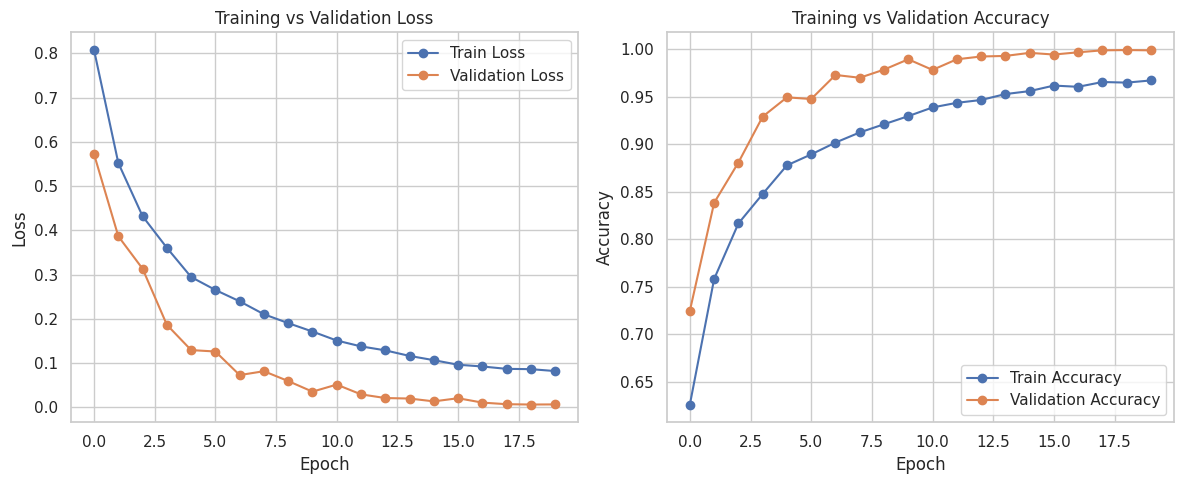

In [20]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(resnet_train_losses, label="Train Loss", marker="o")
plt.plot(resnet_val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(resnet_train_accs, label="Train Accuracy", marker="o")
plt.plot(resnet_val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Overall Test Accuracy: 0.9965

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       885
ModerateDemented       1.00      1.00      1.00       638
     NonDemented       0.99      1.00      0.99       992
VeryMildDemented       1.00      0.99      0.99       884

        accuracy                           1.00      3399
       macro avg       1.00      1.00      1.00      3399
    weighted avg       1.00      1.00      1.00      3399



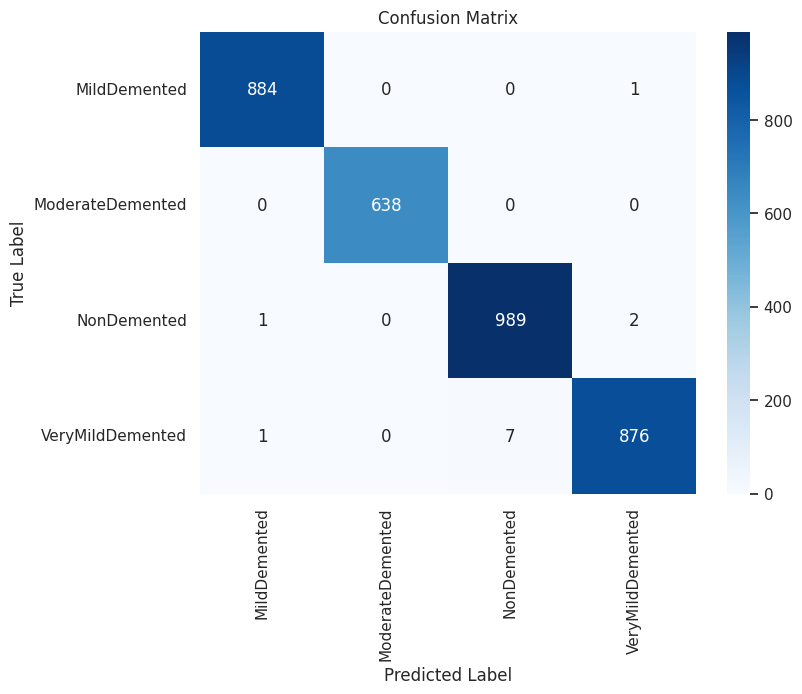

Per Class Accuracy:
Class 0 (MildDemented): 0.9989
Class 1 (ModerateDemented): 1.0000
Class 2 (NonDemented): 0.9970
Class 3 (VeryMildDemented): 0.9910
Final Results for ResNet50:
Overall Accuracy: 0.9965

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       885
ModerateDemented       1.00      1.00      1.00       638
     NonDemented       0.99      1.00      0.99       992
VeryMildDemented       1.00      0.99      0.99       884

        accuracy                           1.00      3399
       macro avg       1.00      1.00      1.00      3399
    weighted avg       1.00      1.00      1.00      3399


Per Class Accuracy:
Class 0: 0.9989
Class 1: 1.0000
Class 2: 0.9970
Class 3: 0.9910


In [21]:
overall_acc, class_report, per_class_acc = test_model_with_report(trained_resnet50, test_loader, device)

results = {
    "ResNet50": {
        "overall_accuracy": overall_acc,
        "classification_report": class_report,
        "per_class_accuracy": per_class_acc
    }
}

print("Final Results for ResNet50:")

overall_acc = results["ResNet50"]["overall_accuracy"]
print("Overall Accuracy: {:.4f}".format(overall_acc))

print("\nClassification Report:\n")
print(results["ResNet50"]["classification_report"])

print("\nPer Class Accuracy:")
per_class_acc = results["ResNet50"]["per_class_accuracy"]
for idx, acc in enumerate(per_class_acc):
    print("Class {}: {:.4f}".format(idx, acc))